# Linear Regression

We'll work with housing data for the city of Ames, Iowa, United States from 2006 to 2010 and use a linear regression model to predict the prices of house.

Let's start by setting up a pipeline of functions that will let us quickly iterate on different models.

In [1]:
import pandas as pd, numpy as np
pd.options.display.max_columns = 999
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
%matplotlib inline 

houses = pd.read_csv("AmesHousing.tsv", delimiter='\t')
houses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 82 columns):
Order              2930 non-null int64
PID                2930 non-null int64
MS SubClass        2930 non-null int64
MS Zoning          2930 non-null object
Lot Frontage       2440 non-null float64
Lot Area           2930 non-null int64
Street             2930 non-null object
Alley              198 non-null object
Lot Shape          2930 non-null object
Land Contour       2930 non-null object
Utilities          2930 non-null object
Lot Config         2930 non-null object
Land Slope         2930 non-null object
Neighborhood       2930 non-null object
Condition 1        2930 non-null object
Condition 2        2930 non-null object
Bldg Type          2930 non-null object
House Style        2930 non-null object
Overall Qual       2930 non-null int64
Overall Cond       2930 non-null int64
Year Built         2930 non-null int64
Year Remod/Add     2930 non-null int64
Roof Style         29

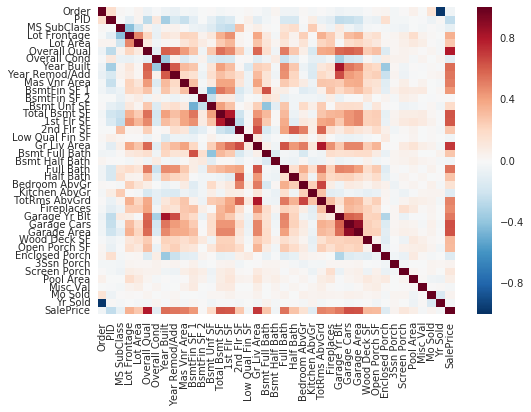

In [2]:
#correlaton matrix to determine what columns can be dropped later on
#some columns may hold the same information and therefore we can remove duplicates 
import seaborn as sns
numerical_data = houses.select_dtypes(include=['int64','float64'])
corr = numerical_data.corr()
sns.heatmap(corr)

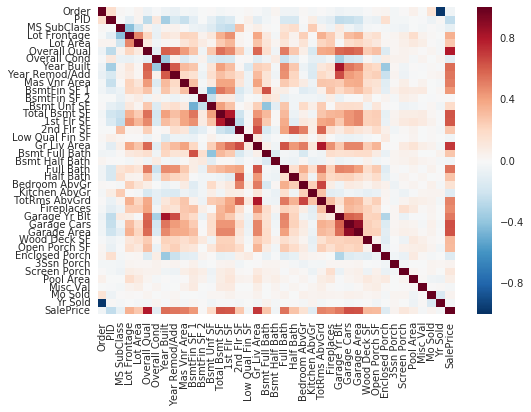

In [3]:
#lets only keep thecolums which correlate reasonably highyl with SalePrice
corr_sale = abs(corr['SalePrice']).sort_values()
relevant_columns = corr_sale[corr_sale > 0.3].index
relevant_numerical_data = numerical_data[relevant_columns]
updated_corr = numerical_data.corr()
sns.heatmap(updated_corr)

In [4]:

def transform_features():
    
    return

In [5]:
#by reading the documentation, transform features to be more usable
def transform_features(df):
    new_df = df.copy()
    
    #more information can be obtained by combining columns regarding year
    #relative house age. Use 2010 as cut off point
    new_df['House Age'] = max(new_df['Yr Sold']) - new_df['Year Built'] 
    new_df = new_df[new_df['House Age'] >= 0]
    
    ## No longer need original year columns, we can also lose the Garage Cars column since it containis
    #mostly the same infomation as Garage Area
    new_df.drop(["Year Built", "Year Remod/Add","Garage Cars"], axis = 1)
    
    
    
    
    #numerical data
    numerical_data = new_df.select_dtypes(include=['int64','float64'])
    numerical_columns = numerical_data.columns
    
    #important categorical data, according to me
    categorical_columns = ['MS Zoning','Lot Config','Neighborhood',
                          'Bldg Type','Exter Qual','Foundation','Heating',
                          'Electrical','Kitchen Qual','Functional',
                          ]
  
    # columns "Mo Sold", "Sale Condition", "Sale Type", "Yr Sold" leak data about sales and so they have been left out
    combined_relevant_columns = list(numerical_columns) + categorical_columns
    new_df = new_df[combined_relevant_columns]
    
    
    #columns with many null values can be ignored (>25%)
    null_values_percent = new_df.isnull().sum()/len(df)
    keep_columns = null_values_percent[null_values_percent<=0.25].index
    new_df = new_df[keep_columns]
    
    #for columns with 5% null values, we can replace with most popular
    less_than_5_percent_columns = null_values_percent[null_values_percent<0.05].index
    less_than_5_percent_modes = new_df[less_than_5_percent_columns].mode().iloc[0,:]
    new_df[less_than_5_percent_columns] = new_df[less_than_5_percent_columns].fillna(less_than_5_percent_modes)
    
    #now for the remaining with NAN percentages of 5<x<25
    #Most of the columns with such NAN amounts have been discaded already. The only two which havent
    #is 'Lot Frontage' and 'Garage Year Built'. The latter is largely irrelevant.
    new_df = new_df.drop(labels=['Garage Yr Blt'],axis=1)
    keep_columns.drop('Garage Yr Blt')
    
    #The Former requires some looking, most of the Properties with missing values have large amounts of rooms above ground
    #so lets fill these values with the mean lot frontage values for poperties with more than 6 rooms abovr ground
    replacement = new_df.loc[new_df['TotRms AbvGrd']>6,'Lot Frontage'].mean()
    new_df['Lot Frontage'] = new_df['Lot Frontage'].fillna(replacement)

    
    return new_df
    
   

In [33]:
#by reading the documentation, transform features to be more usable
def select_features(df, corr_coef=0.4,uniq_threshold=28, category_var=0.9):
    new_df = df.copy()
    
    
    #numerical data, only keep those with correlation coeficients > corr_coef
    numerical_data = new_df.select_dtypes(include=['int64','float64'])
    corr = numerical_data.corr()
    corr_sale = abs(corr['SalePrice']).sort_values()
    relevant_numerical_columns = corr_sale[corr_sale > corr_coef].index
    relevant_numerical_data = numerical_data[relevant_numerical_columns]
    updated_corr = numerical_data.corr()
    
    #important categorical data, according to me, some could have been removed by transform
    categorical_columns = ['MS Zoning','Lot Config','Neighborhood',
                          'Bldg Type','Exter Qual','Foundation','Heating',
                          'Electrical','Kitchen Qual','Functional',
                          ]
    
    
    
    #if a category columns has low variability, we can exclude it
    for cat in categorical_columns:
        #if the transform function didnt remove it
        if cat in new_df.columns:
            values = new_df[cat].value_counts(dropna=False,normalize=True)
            #if the most frequent column makes up 70% of the data, remove that column,  else keep it
            if values[0] > category_var:
                categorical_columns.remove(cat)
        else:
            categorical_columns.remove(cat)
    
    # columns "Mo Sold", "Sale Condition", "Sale Type", "Yr Sold" leak data about sales and so they have been left out
    combined_relevant_columns = list(relevant_numerical_columns) + categorical_columns
    new_df = new_df[combined_relevant_columns]
    
    #ensure categories with many unique values do not get turned into dummies. This could cause
    #the amount of columns to grow by a very large amount. Set at 28 to accomoodate 'Neighbourhood'
    unique_vals_in_categories = new_df[categorical_columns].apply(lambda col: len(col.value_counts()))
    high_unique_columns = unique_vals_in_categories[unique_vals_in_categories > uniq_threshold].index
    new_df = new_df.drop(high_unique_columns,axis=1)
    for cat in categorical_columns:
        if cat in high_unique_columns:
            categorical_columns.remove(cat)
    

    #one hot encoding of categorical data
    new_df = pd.get_dummies(new_df, columns=categorical_columns)

    
    return new_df
    
   

In [34]:
def train_and_test(data):
    
    train = data[:1460]
    test = data[1460:]
    lr = LinearRegression()
    
    #only numerical data
    #numerical_data = houses.select_dtypes(include=['int64','float64']).columns
    numerical_train = train.select_dtypes(include=['int64','float64'])
    numerical_test = test.select_dtypes(include=['int64','float64'])


    features = numerical_train.columns.drop('SalePrice')
    
    #fit the linear regrssor model coeficients 
    lr.fit(train[features],train['SalePrice'])
    predictions = lr.predict(test[features])
    rmse = np.sqrt(mean_squared_error(test['SalePrice'], predictions))
    return rmse

In [35]:
#first attempt 
df = transform_features(houses)
selected = select_features(df)
rmse = train_and_test(selected)
rmse

40685.138830889795

In [36]:
df

,Order,PID,MS SubClass,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,BsmtFin SF 1,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,TotRms AbvGrd,Fireplaces,Garage Cars,Garage Area,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,SalePrice,House Age,MS Zoning,Lot Config,Neighborhood,Bldg Type,Exter Qual,Foundation,Heating,Electrical,Kitchen Qual,Functional
0,1,526301100,20,141.000000,31770,6,5,1960,1960,112.0,639.0,0.0,441.0,1080.0,1656,0,0,1656,1.0,0.0,1,0,3,1,7,2,2.0,528.0,210,62,0,0,0,0,0,5,2010,215000,50,RL,Corner,NAmes,1Fam,TA,CBlock,GasA,SBrkr,TA,Typ
1,2,526350040,20,80.000000,11622,5,6,1961,1961,0.0,468.0,144.0,270.0,882.0,896,0,0,896,0.0,0.0,1,0,2,1,5,0,1.0,730.0,140,0,0,0,120,0,0,6,2010,105000,49,RH,Inside,NAmes,1Fam,TA,CBlock,GasA,SBrkr,TA,Typ
2,3,526351010,20,81.000000,14267,6,6,1958,1958,108.0,923.0,0.0,406.0,1329.0,1329,0,0,1329,0.0,0.0,1,1,3,1,6,0,1.0,312.0,393,36,0,0,0,0,12500,6,2010,172000,52,RL,Corner,NAmes,1Fam,TA,CBlock,GasA,SBrkr,Gd,Typ
3,4,526353030,20,93.000000,11160,7,5,1968,1968,0.0,1065.0,0.0,1045.0,2110.0,2110,0,0,2110,1.0,0.0,2,1,3,1,8,2,2.0,522.0,0,0,0,0,0,0,0,4,2010,244000,42,RL,Corner,NAmes,1Fam,Gd,CBlock,GasA,SBrkr,Ex,Typ
4,5,527105010,60,74.000000,13830,5,5,1997,1998,0.0,791.0,0.0,137.0,928.0,928,701,0,1629,0.0,0.0,2,1,3,1,6,1,2.0,482.0,212,34,0,0,0,0,0,3,2010,189900,13,RL,Inside,Gilbert,1Fam,TA,PConc,GasA,SBrkr,TA,Typ
5,6,527105030,60,78.000000,9978,6,6,1998,1998,20.0,602.0,0.0,324.0,926.0,926,678,0,1604,0.0,0.0,2,1,3,1,7,1,2.0,470.0,360,36,0,0,0,0,0,6,2010,195500,12,RL,Inside,Gilbert,1Fam,TA,PConc,GasA,SBrkr,Gd,Typ
6,7,527127150,120,41.000000,4920,8,5,2001,2001,0.0,616.0,0.0,722.0,1338.0,1338,0,0,1338,1.0,0.0,2,0,2,1,6,0,2.0,582.0,0,0,170,0,0,0,0,4,2010,213500,9,RL,Inside,StoneBr,TwnhsE,Gd,PConc,GasA,SBrkr,Gd,Typ
7,8,527145080,120,43.000000,5005,8,5,1992,1992,0.0,263.0,0.0,1017.0,1280.0,1280,0,0,1280,0.0,0.0,2,0,2,1,5,0,2.0,506.0,0,82,0,0,144,0,0,1,2010,191500,18,RL,Inside,StoneBr,TwnhsE,Gd,PConc,GasA,SBrkr,Gd,Typ
8,9,527146030,120,39.000000,5389,8,5,1995,1996,0.0,1180.0,0.0,415.0,1595.0,1616,0,0,1616,1.0,0.0,2,0,2,1,5,1,2.0,608.0,237,152,0,0,0,0,0,3,2010,236500,15,RL,Inside,StoneBr,TwnhsE,Gd,PConc,GasA,SBrkr,Gd,Typ
9,10,527162130,60,60.000000,7500,7,5,1999,1999,0.0,0.0,0.0,994.0,994.0,1028,776,0,1804,0.0,0.0,2,1,3,1,7,1,2.0,442.0,140,60,0,0,0,0,0,6,2010,189000,11,RL,Inside,Gilbert,1Fam,TA,PConc,GasA,SBrkr,Gd,Typ


In [37]:
#which columsn correlate most strongly with SalePrice
#we only wan


Gr Liv Area and garage size correlates most strongly with SalePrice.

In [38]:
#using only the Gr Living Area column first
data = transform_features(houses)
data = select_features(data)
rmse = train_and_test(data)

In [39]:
rmse

40685.138830889795

# Transform our features 
Let's now start removing features with many missing values, diving deeper into potential categorical features, and transforming text and numerical columns. 

We will update transform_features() so that any column from the data frame with more than 25% (or another cutoff value) missing values is dropped. We also need to remove any columns that leak information about the sale (e.g. like the year the sale happened). In general, the goal of this function is to:

- remove features that we don't want to use in the model, just based on the number of missing values or data leakage
- transform features into the proper format (numerical to categorical, scaling numerical, filling in missing values, etc)
- create new features by combining other features

# K Fold

In [40]:
from sklearn.model_selection import KFold
def train_and_test_k_fold(data, k=4):
    
    rmses=[]
    lr = LinearRegression()
    
    
    if(k == 0):
        train = data[:1460]
        test = data[1460:]
        features = train.columns.drop('SalePrice')
    
        lr.fit(train[features],train['SalePrice'])
        predictions = lr.predict(test[features])
        rmse = np.sqrt(mean_squared_error(test['SalePrice'], predictions))
        rmses.append(rmse)
    
    if(k == 1):
        print()
        
        
    else:
        kf = KFold(n_splits=k, shuffle=True)
        for train_ind, test_ind in kf.split(data):
            train = data.iloc[train_ind]
            test = data.iloc[test_ind]
            features = train.columns.drop('SalePrice')
    
            lr.fit(train[features],train['SalePrice'])
            predictions = lr.predict(test[features])
            rmse = np.sqrt(mean_squared_error(test['SalePrice'], predictions))
            rmses.append(rmse)
    


    avg_rmse = np.mean(rmses)
    return avg_rmse

In [41]:
train_and_test_k_fold(data,4)

29668.42356102229

In [ ]:
len(df)/2

In [ ]:
df